In [3]:
## Parameter initialization (clear all)
from IPython import get_ipython
get_ipython().magic('reset -sf')

import os
import pandas as pd
import scipy.io as sio
import numpy as np
from scipy.signal import butter, filtfilt, resample 
import matplotlib.pyplot as plt

# Prepare to extract data from .csv files

main_path = '<insert path to folder containing Consolidated_Features subfolder>'
features_path = main_path + 'Consolidated_Features'

Subject = os.listdir(features_path) # Post_MI: 35, Healthy: 9
Subject.remove('.DS_Store')
NumSub = np.size(Subject)
subj_list = [
    "3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
    "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
    "3154", "3155", "3156", "3158", "3159", "3160", "3162", "6037", "6038", 
    "6043", "6044", "6045", "6046", "6047", "6048", "6049"]
NumStim = 5
Stimulus = ['Rest', 'Reading', 'SpeechPrep', 'Speech', 'Recovery']
NumFeat = 5
Feature = ['HR', 'PAT', 'PEP', 'PPGamp', 'PTTrecip']
Unit = ['bpm', 's', 's', 'au', '1/s']
# 1st column: time, second column: feature values
Subj = np.zeros(len(Subject))
for i in range(len(Subject)):
    Subj[i] = int(Subject[i][3:])  
Subj.sort()

In [4]:
# Extract physio features from .csv files
dataframes_MI = []
dataframes_Ht = []
sub_MI = -1;
sub_Ht = -1;
for sub in range(NumSub):
    if str(round(Subj[sub])) in subj_list:
        if str(Subj[sub]).startswith('3'):
            sub_MI = sub_MI+1;
            dataframes_MI.append([]) 
            for stim in range(NumStim):
                dataframes_MI[sub_MI].append([]) 
                for feat in range(NumFeat):
                    dataframes_MI[sub_MI][stim].append([]) 
                    Feat_load = os.path.join(features_path, 'sub' + str(int(Subj[sub])), 'stim' + str(stim) + '_' + Feature[feat] + '.csv');
                    data = pd.read_csv(Feat_load)
                    dataframes_MI[sub_MI][stim][feat] = data.values
        if str(Subj[sub]).startswith('6'):
            sub_Ht = sub_Ht+1;
            dataframes_Ht.append([])
            for stim in range(NumStim):
                dataframes_Ht[sub_Ht].append([])
                for feat in range(NumFeat):
                    dataframes_Ht[sub_Ht][stim].append([])
                    Feat_load = os.path.join(features_path, 'sub' + str(int(Subj[sub])), 'stim' + str(stim) + '_' + Feature[feat] + '.csv');
                    data = pd.read_csv(Feat_load)
                    dataframes_Ht[sub_Ht][stim][feat] = data.values

In [5]:
# Extract SUDS scores
subj_list = list(map(int, subj_list))
suds = pd.read_csv(main_path + 'suds.csv')
suds = suds[suds.patid.isin(subj_list)]

suds_pre_speech_MI = []
suds_pre_speech_Ht = []

suds_post_speech_MI = []
suds_post_speech_Ht = []

for subj in subj_list:
    
    suds_pre_speech = suds[suds.patid == subj].suds_distress_pre.values[0]
    suds_post_speech = suds[suds.patid == subj].suds_distress_post.values[0]
    
    if str(subj)[0] == '3':
        suds_pre_speech_MI.append(suds_pre_speech)
        suds_post_speech_MI.append(suds_post_speech)
        
    if str(subj)[0] == '6':
        suds_pre_speech_Ht.append(suds_pre_speech)
        suds_post_speech_Ht.append(suds_pre_speech)

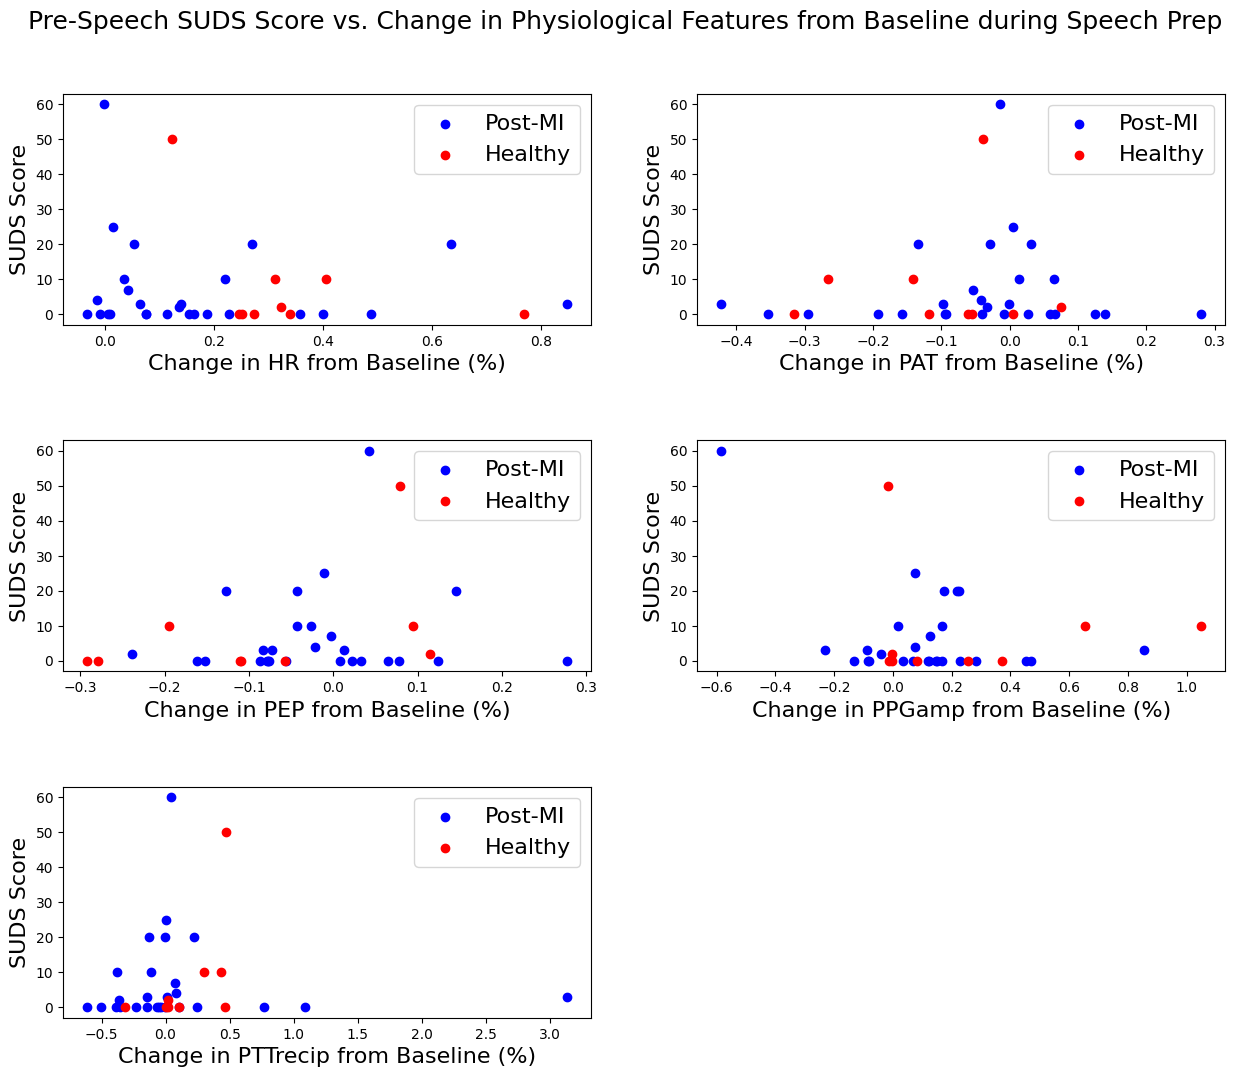

In [9]:
# Isolate features from speech preparation stimulus (stim 2), compute average, and plot against SUDS

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Pre-Speech SUDS Score vs. Change in Physiological Features from Baseline during Speech Prep", fontsize=18, y=0.95)

for i in range(NumFeat):

    speech_prep_feature_MI = []
    speech_prep_feature_HT = []
    
    MI_idx = 0
    Ht_idx = 0
    
    for subj in subj_list:

        if str(subj)[0] == '3':
            baseline = dataframes_MI[MI_idx][0][i][:, 1]
            feature = dataframes_MI[MI_idx][2][i][:, 1]
            speech_prep_feature_MI.append((np.mean(feature) - np.mean(baseline))/np.mean(baseline))
            MI_idx += 1
            
        if str(subj)[0] == '6':
            baseline = dataframes_Ht[Ht_idx][0][i][:, 1]
            feature = dataframes_Ht[Ht_idx][2][i][:, 1]
            speech_prep_feature_HT.append((np.mean(feature) - np.mean(baseline))/np.mean(baseline))
            Ht_idx += 1
            
    ax = plt.subplot(3, 2, i+1)
    ax.scatter(speech_prep_feature_MI, suds_pre_speech_MI, color='b')
    ax.scatter(speech_prep_feature_HT, suds_pre_speech_Ht, color='r')
    ax.set_xlabel('Change in ' + Feature[i] + " from Baseline (%)", fontsize = 16)
    ax.set_ylabel('SUDS Score', fontsize = 16)
    ax.legend(['Post-MI', 'Healthy'], fontsize = 16)